# Обнаружение SQL Инъекций с помощью логистической регрессии (наивный эксперимент)

In [1]:
import pandas as pd
df = pd.read_csv('data/sqli.csv', header=None).append(pd.read_csv('data/sqliv2.csv', header=None)).sort_values(1)
df

,0,1
14779,massimil,0
21103,salvina,0
21104,1059231645093194,0
21105,fogars de la selva,0
21106,53527134q,0
...,...,...
8240,-7034' ) ) ) union all select 4023#,1
8241,"select benchmark ( 5000000,md5 ( 0x4c4d6142 )...",1
8242,1 ) as adzj where 5575 = 5575 or 8421 = ( se...,1
8262,1' ) ) as pstn where 6691 = 6691 and 4241 ...,1


### Замечание
Сортируем для того чтобы потом просто отделить инъекции от обычного текста при предобработке.

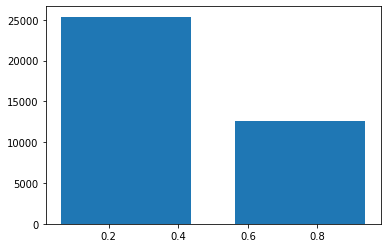

In [2]:
import matplotlib.pyplot as plt
import numpy as np
plt.hist(df[1], bins=2, rwidth=0.75)
plt.show()

## Данные
Набор содержит примерно 25000 экземпляров нормальных параметров запроса и примерно в 2 раза меньше экземпляров инъекций.

In [3]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\alexa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alexa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\alexa\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Препросессинг
1. Токенезация
2. Лемматизация
3. Удаление стоп-слов
4. Конкатенация токенов

In [4]:
lowerize = lambda tokens: (token.lower() for token in tokens)

In [5]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english')) - {'or', 'and', 'select', 'union', 'from', 'where', 'in', 'drop', 'database', 'all', 'any', 'order', 'delete', 'is', 'not', 'join', 'by'}
rm_stop_words = lambda tokens: (token for token in tokens if token not in stop_words)

### Удаление стоп-слов
Исключаются только английские стоп-слова.

In [6]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
lemmatize = lambda tokens: (lemmatizer.lemmatize(token) for token in tokens)

### Лемматизация
Проводится только по словам которые присутсвуют в лемматизаторе WordNet.

In [7]:
from nltk.tokenize import word_tokenize
concat = lambda tokens, sep=' ': sep.join(tokens)
prepocessers = (word_tokenize, lowerize,  concat)

In [8]:
from functools import reduce
compose = lambda funcs: lambda args: reduce(lambda prev, cur: cur(prev), funcs, args)
preprocess = lambda text: compose(prepocessers)(text)

In [9]:
res = [preprocess(text) for text in df[0].values.astype('U')]

## Векторизация
Используется *Количественный векторизатор*.

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()

### Замечание
Выборка разбивается на обучающую и тестовую в следующих размерах - 70% и 30% соответсвенно.

In [11]:
from sklearn.model_selection import train_test_split
X = vectorizer.fit_transform(res)
y = df[1].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Классификатор
В качестве классификатора взята *Логистическая регрессия*.

In [12]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=42).fit(X_train, y_train)

## Результаты
Подсчитывались следующие метрики:
* Accuracy
* F1
* Precision
* Recall

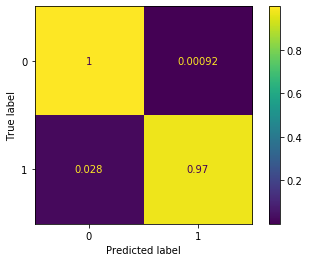

,
accuracy_score,0.990165
f1_score,0.985051
precision_score,0.998107
recall_score,0.972332


In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, plot_confusion_matrix
y_pred = clf.predict(X_test)
scores = (accuracy_score, precision_score, recall_score, f1_score)
results = pd.DataFrame(data={'': {score.__name__: score(y_test, y_pred) for score in scores}})
plot_confusion_matrix(clf, X_test, y_test, normalize='true')
plt.show()
results